In [2]:
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
from inputs.xscatter import get_delta_beta_mix

In [3]:
# My preferred plotting settings.
plt.rcParams.update({
    'figure.dpi': 300,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'image.cmap':'gray'
})

# Materials

In [4]:
class Material:
    """
    Represents a material with its physical properties for imaging simulations.

    This class organizes material properties including density and the complex 
    refractive index components (delta and beta) over a range of X-ray energies. 
    These are computed based on the material's composition using 
    `get_delta_beta_mix`.

    Attributes
    ----------
    name : str
        Name of the material.
    matcomp : str
        Specification of the material composition, compatible with get_delta_beta_mix.
        E.g. -- water is 'H(11.2)O(88.2)'
    density : float
        Mass density of the material (g/cm³).
    energy_range : ndarray
        Array of energies (in keV) over which delta and beta are precomputed.
    delta_range : ndarray
        Precomputed real part of the refractive index decrement over energy_range.
    beta_range : ndarray
        Precomputed imaginary part of the refractive index decrement over energy_range.
    """
    def __init__(self, name, matcomp, density):
        self.name = name
        self.matcomp = matcomp
        self.density = density
        self.energy_range = np.linspace(1, 150, 1000)
        self.delta_range, self.beta_range = get_delta_beta_mix(matcomp, self.energy_range, density)

    def db(self, energy):
        """
        Interpolate and return delta and beta at given energy values.

        Parameters
        ----------
        energy : float or ndarray
            Energy value(s) in keV at which to evaluate delta and beta.

        Returns
        -------
        delta : float or ndarray
            Interpolated real part of the refractive index decrement at the input energy.
        beta : float or ndarray
            Interpolated imaginary part of the refractive index decrement at the input energy.
        """
        delta = np.interp(energy, self.energy_range, self.delta_range)
        beta = np.interp(energy, self.energy_range, self.beta_range)
        return delta, beta

# Two materials relevant for mammo: adipose tissue and fibroglandular tissue.
adip = Material('adipose', 'H(11.2)C(61.9)N(1.7)O(25.1)', 0.93)
gland = Material('gland', 'H(10.2)C(18.4)N(3.2)O(67.6)', 1.04)

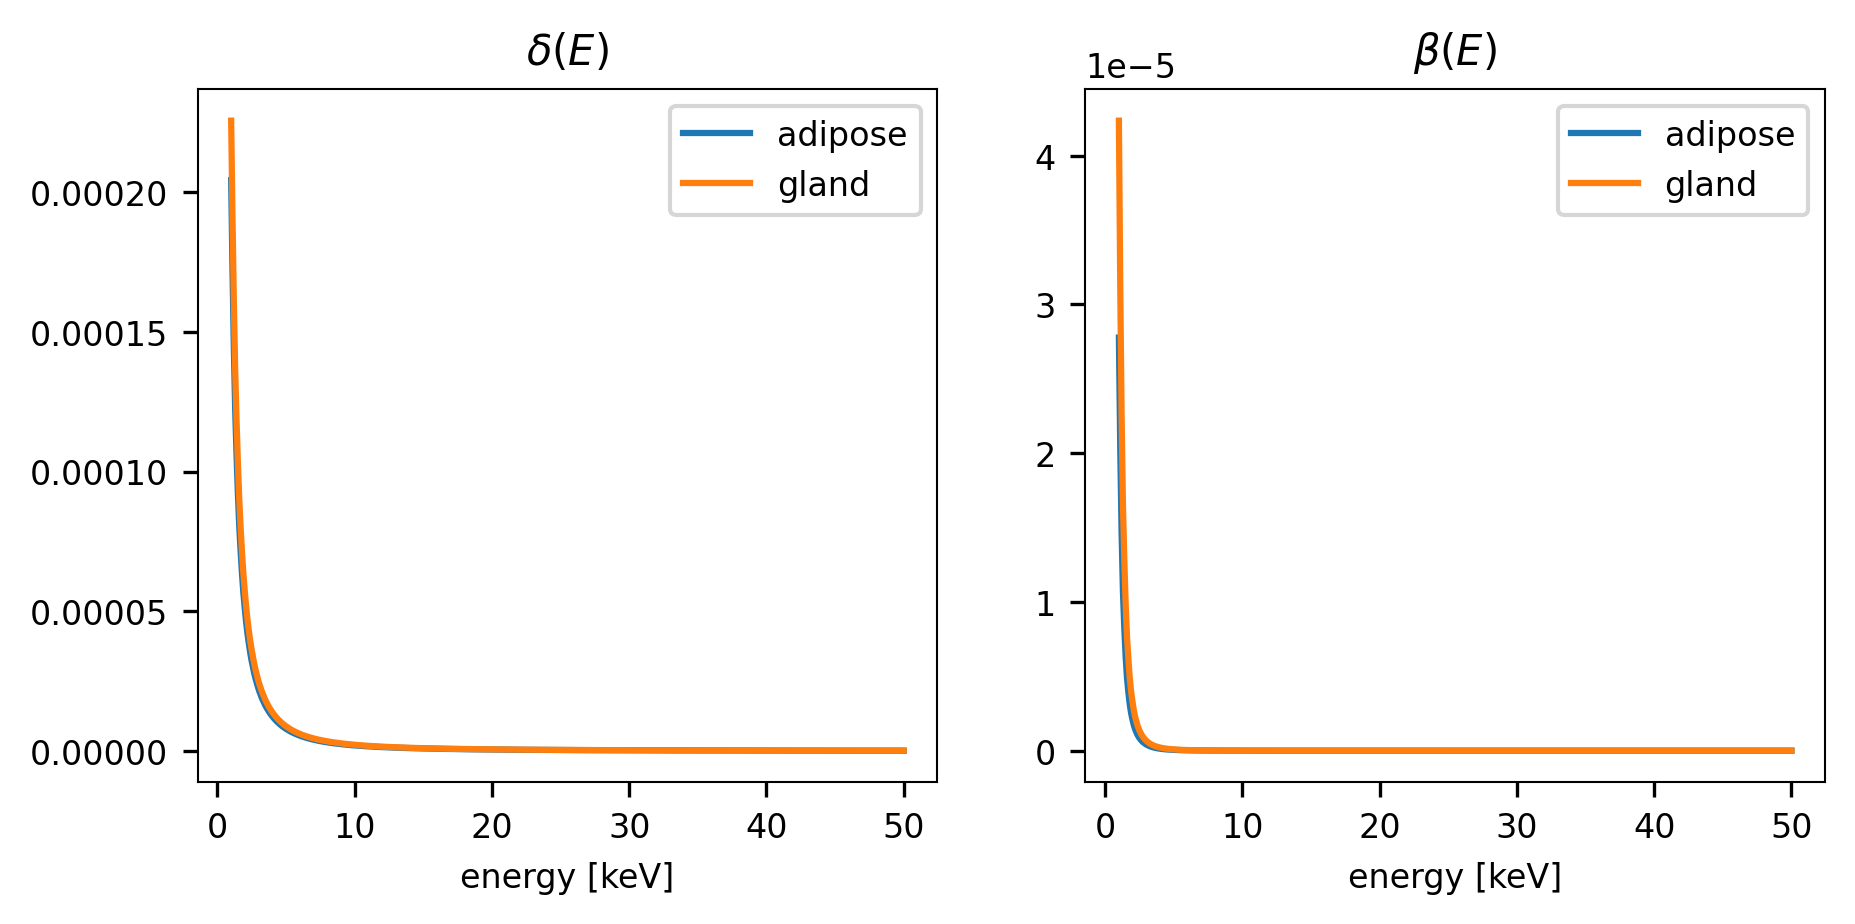

In [11]:
### TODO: Plot delta and beta for energies from 1 to 50 keV for the two materials.

#1 row, 2 cols of subplots; 7 width, 3 height of subplots
fig, ax = plt.subplots(1, 2, figsize=[7,3])
#sets title of subplot 1 in LaTex-style math (delta: refractive index)
ax[0].set_title(r'$\delta(E)$')
#X-axis labeled in kilo-electron-volts
ax[0].set_xlabel('energy [keV]')
#sets title of subplot 2 in LaTex-style math (beta: absorption)
ax[1].set_title(r'$\beta(E)$')
#X-axis labeled in kilo-electron-volts
ax[1].set_xlabel('energy [keV]')

### INSERT YOUR CODE HERE TO FILL IN THE PLOTS
### Make sure to label each curve with its material.name (i.e. `label=adip.name`)

#generation of 500 equally-spaced values from 1 to 50 keV
energies = np.linspace(1, 50, 500)

#ADIPOSE TISSUE plotting
#calling db() method of the Material class: returns two vectors (delta_adip, beta_adip)
delta_adip, beta_adip = adip.db(energies)
ax[0].plot(energies, delta_adip, label=adip.name)
ax[1].plot(energies, beta_adip, label=adip.name)
#GLANDULAR TISSUE plotting
#calling db() method of the Material class: returns two vectors (delta_gland, beta_gland)
delta_gland, beta_gland = gland.db(energies)
ax[0].plot(energies, delta_gland, label=gland.name)
ax[1].plot(energies, beta_gland, label=gland.name)
#adding legends to both subplots
ax[0].legend()
ax[1].legend()
#displaying the plots
plt.show()

# 3D power-law breast phantoms

## helper function — 2D Gaussian

In [15]:
def gaussian2d(N, mu=0, sigma=1, normalize=True):
    """
    Creates a 2D Gaussian kernel over a square grid of size N×N, centered at the origin.
    Useful for image filtering, convolution, or simulating point spread functions.

    Parameters:
    ----------
    N : int
        Size of the output kernel (N x N).
    mu : float, optional
        Mean of the Gaussian distribution. Currently unused, as the kernel is always centered at 0 (default is 0).
    sigma : float, optional
        Standard deviation (spread) of the Gaussian (default is 1).
    normalize : bool, optional
        If True, normalize the kernel so that the sum of all elements equals 1 (default is True).

    Returns:
    -------
    G : ndarray
        A 2D NumPy array of shape (N, N) representing the Gaussian kernel.
    """
    #N.B. Kernel: small matrix used to modify images by applying a rule over every pixel and its neighbors
    #creation of vector x, made up of N equally-spaced points from -N/2 to N/2; this defines the coordinates around the center of the kernel
    x = np.linspace(-N/2, N/2, N)
    #building two 2D arrays X and Y to each contain the X and Y coordinates, respectively
    X, Y = np.meshgrid(x, x)
    #calculation of the value of the Gaussian function at each coordinate point
    G = 1/(2*np.pi*sigma**2) * np.exp(-(X**2 + Y**2)/(2*sigma**2))
    #normalization: ensures that the sum of all values in G equals 1; this is useful when using the kernel as a convolution filter
    #so that the overall brightness stays the same
    if normalize:
        G /= G.sum()
    #2D NumPy array of shape (N, N) representing the Gaussian kernel
    return G

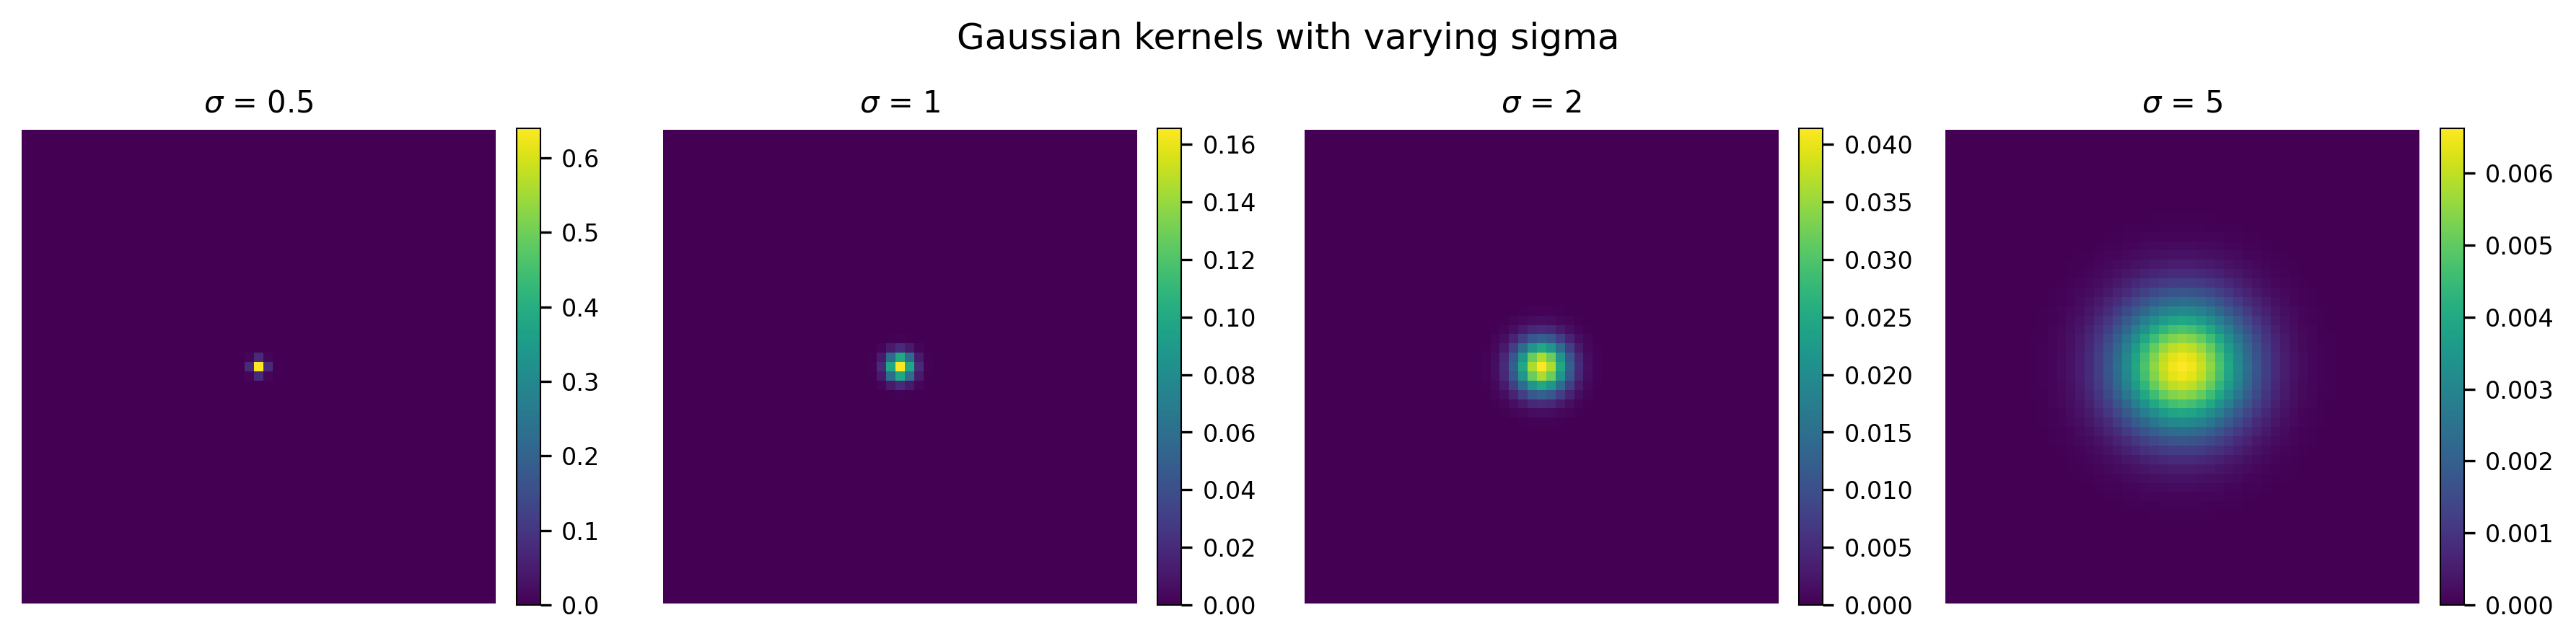

In [13]:
### TODO - generate some Gaussian kernels for different mu and sigma and show the images.
### Make sure to show the colorbar to see the magnitude of the pixel values.

#defining parameters
#kernel size (N.B. odd number is best for symmetry)
N = 51 
#different spreads
sigmas = [0.5, 1, 2, 5]

fig, axes = plt.subplots(1, len(sigmas), figsize=(12, 3))
fig.suptitle("Gaussian kernels with varying sigma")

for i, sigma in enumerate(sigmas):
    G = gaussian2d(N, sigma=sigma)
    
    im = axes[i].imshow(G, cmap='viridis')
    axes[i].set_title(f"$\\sigma$ = {sigma}")
    axes[i].axis('off')
    
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

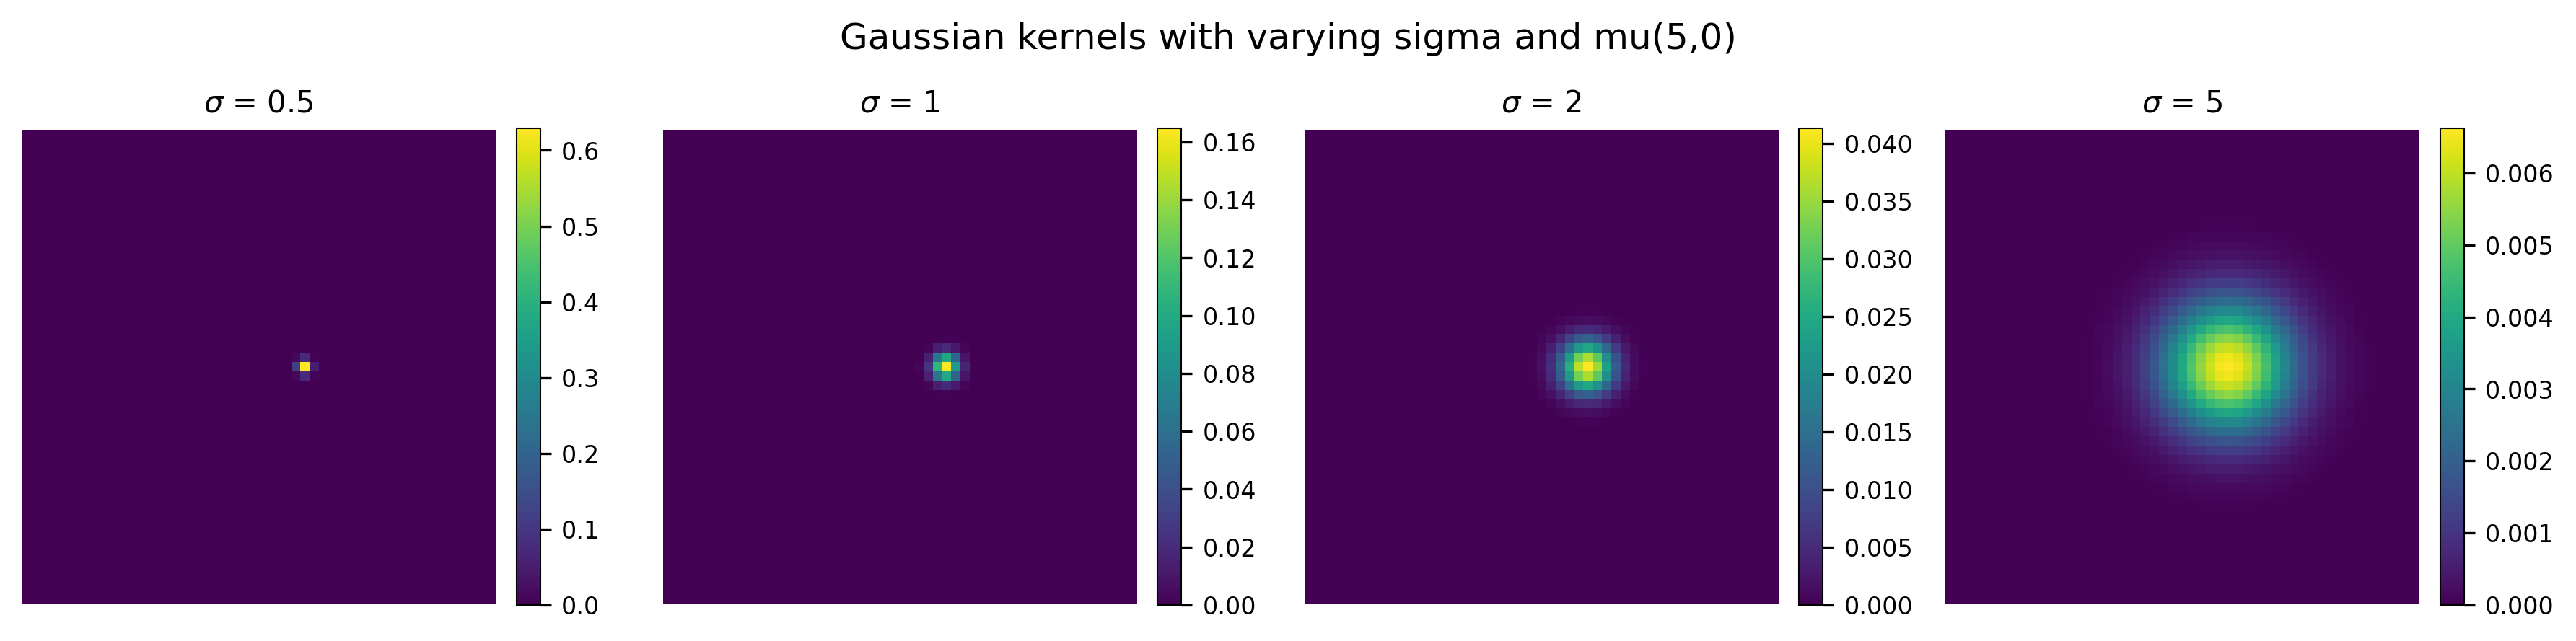

In [23]:
#second function with modified mu values
def gaussian2d_mu(N, mu=(0, 0), sigma=1, normalize=True):
    x = np.linspace(-N/2, N/2, N)
    X, Y = np.meshgrid(x, x)
    G_mu = 1/(2*np.pi*sigma**2) * np.exp(-((X - mu[0])**2 + (Y - mu[1])**2)/(2*sigma**2))
    if normalize:
        G_mu /= G_mu.sum()
    return G_mu

#defining parameters (same as above)
N = 51
sigmas = [0.5, 1, 2, 5]
#addition of shifted mu values
mu = (5, 0)

#second series of plots
fig, axes = plt.subplots(1, len(sigmas), figsize=(12, 3))
fig.suptitle("Gaussian kernels with varying sigma and mu(5,0)")
for i, sigma in enumerate(sigmas):
    G_mu = gaussian2d_mu(N, mu=mu, sigma=sigma)

    im = axes[i].imshow(G_mu, cmap='viridis')
    axes[i].set_title(f"$\\sigma$ = {sigma}")
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

## 2D phantom (just for testing)

In [26]:
def make_phantom_2d(N, dx, kappa=1, beta=3.4, f0=50, normalize=True):
    """
    This function creates a 2D power-law phantom.

    Parameters:
    ----------
    N : int
        Size of the square image (i.e., the output will be of shape (N, N)).
    dx : float
        Spatial sampling interval (pixel size) in each dimension.
    kappa : float, optional
        Amplitude scaling factor for the power-law spectrum (default is 1).
    beta : float, optional
        Exponent of the power-law spectrum (default is 3.4).
    f0 : float, optional
        Frequency offset added to avoid singularity at zero frequency (default is 50).
    normalize : bool, optional
        If True, normalize the output image to have a maximum value of 1 (default is True).

    Returns:
    -------
    img : ndarray
        A 2D NumPy array of shape (N, N) representing the synthetic power-law phantom.
    """
    # Generate the spatial and frequency coordinates.
    #generation of an array of spatial coordinates; dx equals the pixel size (in meters!)
    x = dx * np.linspace(-N/2, N/2, N)
    #generation of frequency coordinates (within fx); fftshift() rearranges these coordinates so that the zero frequency is centered; the "+ f0" avoids
    #the division by zero/singularity problem
    fx = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) + f0
    #creating a 2D frequency grid
    FX, FY = np.meshgrid(fx, fx)
    #magnitude of the frequency at each point
    F = np.sqrt(FX**2 + FY**2)

    # Generate the frequency-domain representation.
    #introducing randomness to make the image texture more natural; there is a random phase angle for each frequency component
    phi = np.pi * (2 * np.random.random_sample((N, N)) - 1)
    #building the complex-valued frequency spectrum: power-law behavior applies (i.e. higher frequencies get weaker)
    #N.B. Kappa = amplitude scaler in the frequency domain (i.e. increases/decreases overall brightness/contrast)
    #N.B. Beta = power-law exponent which controls how fast high-frequency components decay 
    #     (small beta: rough, noisy texture; large beta = smooth and blurry texture)
    V = np.exp(-1j * phi) * np.sqrt(kappa / (F + f0)**beta)

    # Inverse FFT to generate spatial-domain image.
    #use of an inverse FFT to move from the frequency to the spatial domain; abs() provides a real-valued image (so no complex phase)
    img = np.abs(np.fft.ifft2(V))
    #scaling of all pixels to be between 0 and 1
    if normalize:
        img /= img.max()
    return img

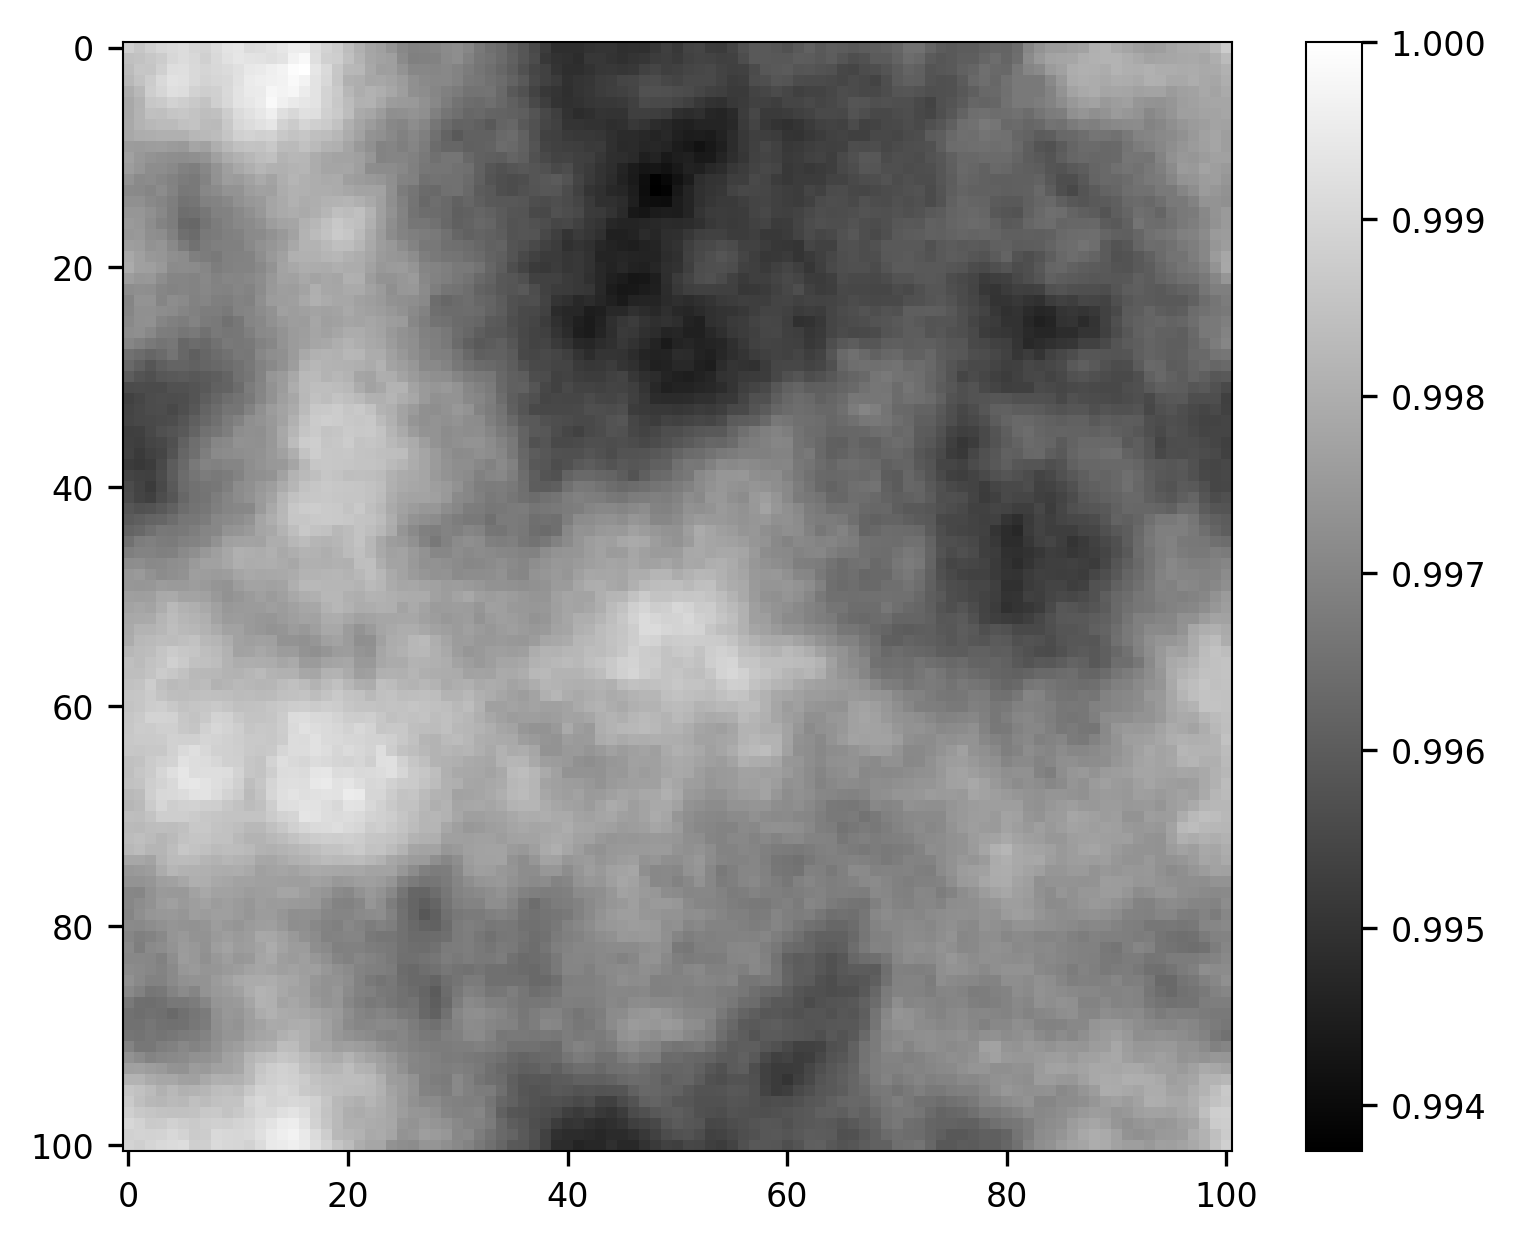

In [27]:
# Test to see what it looks like:
N = 101
dx = 1e-6
phantom = make_phantom_2d(N, dx)
plt.imshow(phantom)
plt.colorbar()
plt.show()

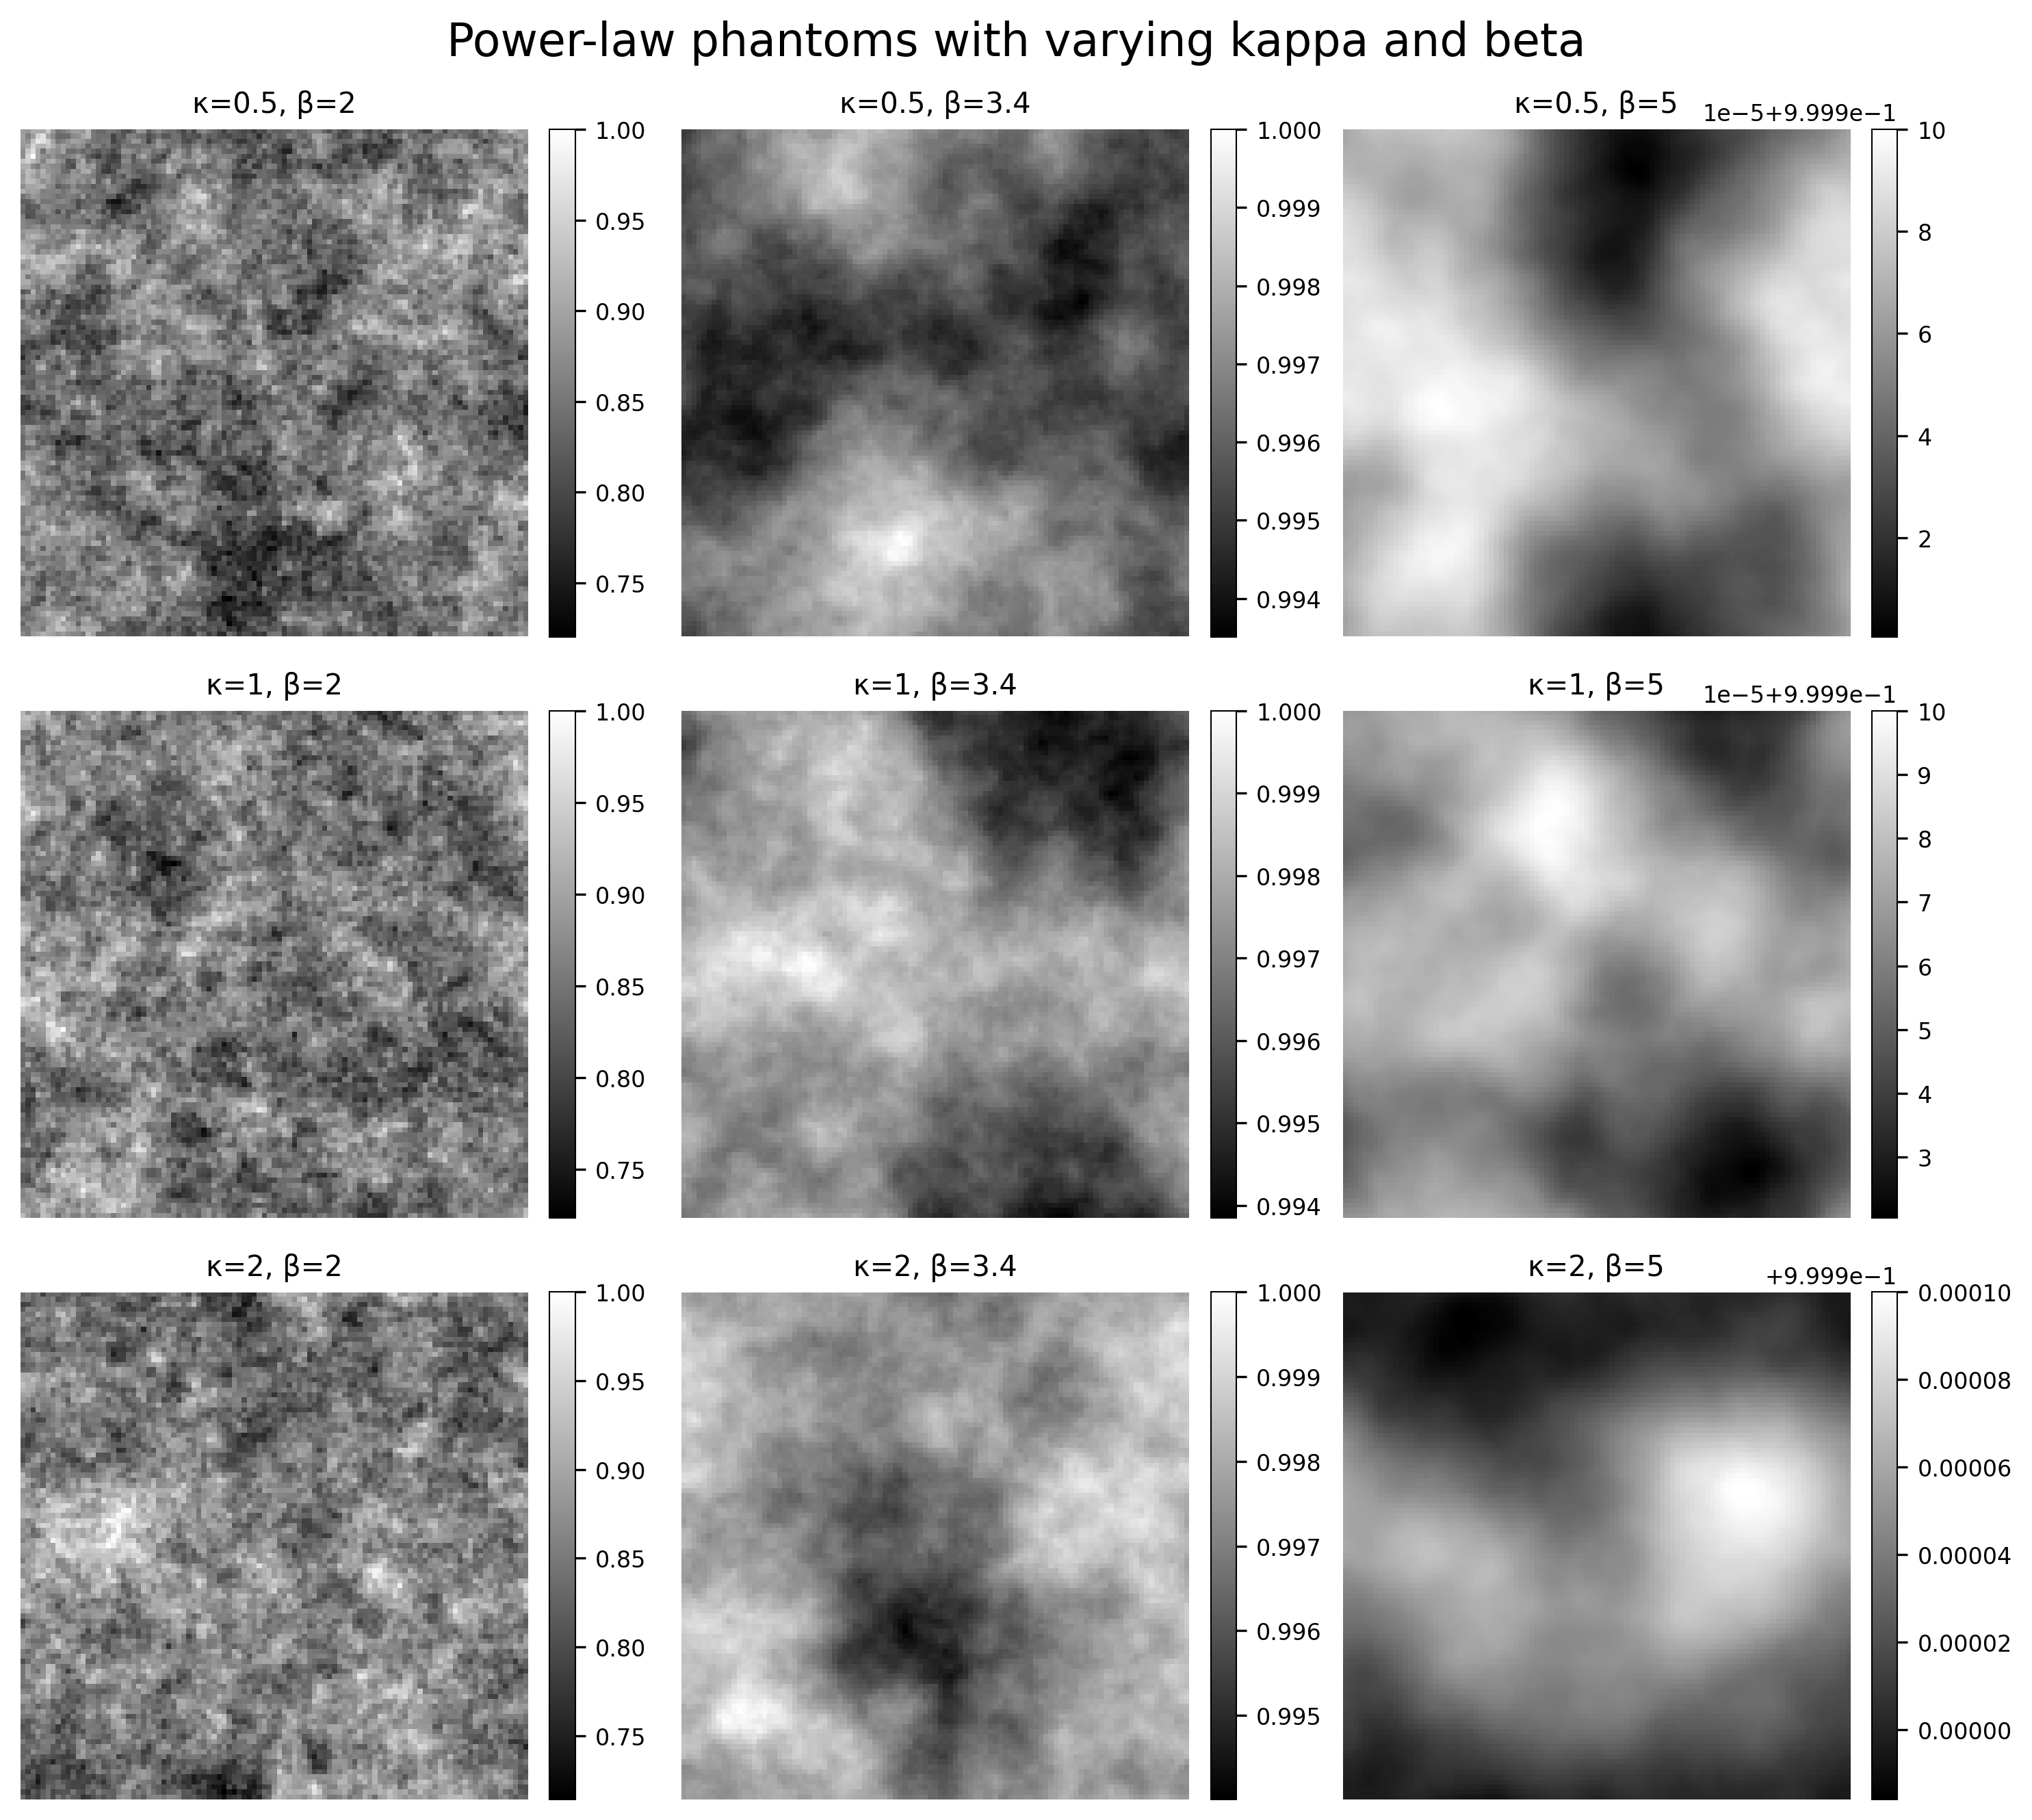

In [28]:
### TODO: generate and show 2D phantoms for a few different kappa, beta.
### How do kappa and beta affect the phantom structure?

#defining parameters
N = 101
dx = 1e-6
kappas = [0.5, 1, 2]
betas = [2, 3.4, 5]

#plot and subplot
fig, axes = plt.subplots(len(kappas), len(betas), figsize=(10, 9))
fig.suptitle("Power-law phantoms with varying kappa and beta", fontsize=16)
for i, kappa in enumerate(kappas):
    for j, beta in enumerate(betas):
        phantom = make_phantom_2d(N, dx, kappa=kappa, beta=beta)
        ax = axes[i, j]
        im = ax.imshow(phantom, cmap='gray')
        ax.set_title(f"κ={kappa}, β={beta}")
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

## 3D phantom (for actual use)

In [ ]:
def make_phantom(N, dx, kappa=1, beta=3.4, f0=50, normalize=True):
    """
    This function creates a volumetric phantom whose spatial frequency content 
    follows a power-law distribution, commonly used to simulate the noise-like 
    texture of anatomical backgrounds in medical imaging (e.g. breast)

    Parameters:
    ----------
    N : int
        Size of the cubic volume (i.e., the output volume will be of shape (N, N, N)).
    dx : float
        Spatial sampling interval (voxel size) in each dimension.
    kappa : float, optional
        Amplitude scaling factor for the power-law spectrum (default is 1).
    beta : float, optional
        Exponent of the power-law spectrum (default is 3.4, typical for breast tissue).
    f0 : float, optional
        Frequency offset added to avoid singularity at zero frequency (default is 50).
    normalize : bool, optional
        If True, normalize the output volume to have a maximum value of 1 (default is True).

    Returns:
    -------
    vol : ndarray
        A 3D NumPy array of shape (N, N, N) representing the synthetic power-law phantom.
    """
    # Generate the spatial and frequency coordinates.
    x = dx*np.linspace(-N/2, N/2, N)
    fx = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) + f0
    FX, FY, FZ = np.meshgrid(fx, fx, fx)
    F = np.sqrt(FX**2 + FY**2 + FZ**2) 

    # Generate the volume.
    phi = np.pi * (2*np.random.random_sample((N,N,N))-1)   
    V = np.exp(-1j*phi) * np.sqrt(kappa / (F+f0)**beta)
    vol = np.abs(np.fft.ifftn(V))
    
    if normalize:
        vol /= vol.max()
    
    return vol

In [ ]:
# Test the function.
vol = make_phantom(501, 1e-6)

# Check a few slices and make sure that adjacent slices vary slowly.
# WARNING --- do not try to plot the whole phantom or every slice unless N is small.
fig, ax = plt.subplots(1, 5, figsize=[12, 2])
for i in range(len(ax)):
    m = ax[i].imshow(vol[:,N//2 + 5*i])
    fig.colorbar(m, ax=ax[i])
    ax[i].axis('off')
fig.tight_layout()
plt.show()

## add ellipsoid "envelope" for curved edges
### thickness map "tmap"

In [ ]:
def tmap_ellipsoid(N, rx, ry, xc=0, yc=0, angle=None):
    """
    Generate a 2D elliptical envelope mask for phantom structuring.

    This function creates an ellipsoidal transparency map (tmap) over a square grid.
    The map defines a soft mask where values inside the ellipse are nonzero and values
    outside are zero, allowing you to spatially modulate background textures (e.g., 
    power-law phantoms) into more anatomically plausible shapes. The ellipse can be
    optionally rotated.

    Parameters
    ----------
    N : int
        Size of the square output array (N x N).
    rx : float
        Semi-axis length of the ellipse in the x-direction.
    ry : float
        Semi-axis length of the ellipse in the y-direction.
    xc : float, optional
        x-coordinate of the ellipse center (default is 0, centered).
    yc : float, optional
        y-coordinate of the ellipse center (default is 0, centered).
    angle : float, optional
        Angle in degrees to rotate the ellipse counterclockwise (default is None, no rotation).

    Returns
    -------
    tmap : ndarray
        A 2D NumPy array of shape (N, N) containing values in [0, 1],
        representing the elliptical mask. Values are 0 outside the ellipse,
        and decrease quadratically toward the boundary inside.
    """
    x = np.linspace(-N/2, N/2, N)
    X, Y = np.meshgrid(x, x)
    tmap = 1 - ((X - xc)/rx)**2 - ((Y - yc)/ry)**2  
    tmap[tmap < 0] = 0  
    if angle is not None:
        tmap = rotate(tmap, angle, reshape=False)
    return tmap

In [ ]:
### TODO: plot an image of `tmap` with colorbar.
### Make sure you understand each input parameter and its effect.

tmap = tmap_ellipsoid(100, 35, 42, angle=20)  # the test tmap

## segment the phantom into two materials

In [ ]:
def thresh_texture(vol, d):
    """
    Convert a continuous phantom texture into a binary mask using a top percentile threshold.
    This function thresholds the input volume such that a fraction `d` of voxels with the 
    highest intensities are set to 1 (representing one material), and all others are set to 0 
    (representing a second material). It effectively binarizes a background texture into 
    two discrete material regions.

    Note that this might take a while to run depending on your machine and the volume size.

    Parameters
    ----------
    vol : ndarray
        Input 2D or 3D NumPy array containing the background texture (e.g., power-law phantom).
    d : float
        Desired fraction of voxels to assign to the higher-intensity material. 
        Must be between 0 and 1.

    Returns
    -------
    mask : ndarray
        Binary NumPy array of the same shape as `vol`, where the top `d` fraction of intensities 
        are 1 and the rest are 0.
    """
    assert 0 < d < 1, 'd must be between 0 and 1 (exclusive)'
    thresh = np.quantile(vol, 1 - d)
    mask = (vol > thresh).astype(np.uint8)
    return mask

In [ ]:
# Testing the function
vol = make_phantom(101, 1e-6)
mask = thresh_texture(vol, 0.4)

# Making a test plot
zval = vol.shape[0]//2   # a central z-value 
zslice = mask[zval]     
projection = np.sum(mask, axis=0)  # a projection along the z-axis

fig, ax = plt.subplots(1, 2, figsize=[8,3], layout='constrained')
ax[0].set_title(f'z={zval} slice')
m = ax[0].imshow(zslice)
fig.colorbar(m, ax=ax[0])
ax[1].set_title('z projection')
m = ax[1].imshow(projection)
fig.colorbar(m, ax=ax[1])
plt.show()

In [ ]:
### TODO: Show `thresh_texture` zslices and projections for six different voxel fractions.
### Format each figure so that each zslice/projection is one panel in a horizontal row.
### Title each panel with `d` and make sure to show a colorbar.
### You can use a smaller `N` to speed up the code if needed.

d_vals = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]   # voxel fractions


## convert the binary mask into physical delta, beta values

In [ ]:
def make_db_vol(vol, mat_dict, energy):
    """
    Generate 3D volumes of delta and beta values for a phantom at given energy or energies.
    For each material label in the phantom volume, this function assigns the corresponding 
    refractive index decrement (delta) and absorption index (beta) values at the specified 
    energy/energies to all voxels of that material. The output volumes represent the spatial 
    distribution of delta and beta throughout the phantom.

    Parameters
    ----------
    vol : ndarray, shape (Nz, Ny, Nx)
        3D NumPy array representing the phantom, where each voxel's value is an integer label 
        identifying the material at that location.
    mat_dict : dict
        Dictionary mapping integer material labels to Material objects. Each Material object 
        must have a `.db(energy)` method that returns (delta, beta) at the given energy.
        There should be a key for each unique value in `vol`, otherwise the default is vacuum.
    energy : float or ndarray of shape (Ne,)
        Energy value(s) at which to compute delta and beta.

    Returns
    -------
    delta_vol : ndarray, shape (Ne, Nz, Ny, Nx)
        3D NumPy array containing the delta values assigned per energy and voxel.
    beta_vol : ndarray, shape (Ne, Nz, Ny, Nx)
        3D NumPy array containing the beta values assigned per energy and voxel.
    """

    energy = np.atleast_1d(energy)
    Ne = energy.size
    
    # Prepare lookup tables for indexing
    max_label = int(vol.max())
    delta_lookup = np.zeros((Ne, max_label+1), dtype=np.float32)
    beta_lookup = np.zeros((Ne, max_label+1), dtype=np.float32)

    for m, mat in mat_dict.items():
        delta, beta = mat.db(energy)
        delta_lookup[:, m] = delta
        beta_lookup[:, m] = beta

    # Create volumes with vectorized indexing
    vol_delta = delta_lookup[:, vol] 
    vol_beta = beta_lookup[:, vol]

    return vol_delta, vol_beta

# Main

Combine everything to make example delta, beta projections.

In [ ]:
%%time 

############################################################
### PARAMETERS

energy = 20  # energy [keV] for evaluating the delta, beta values

# Phantom dimensions and resolution
N = 101     # num voxels in x,y direction
Nz = 20     # num voxels in z direction (make it smaller to save memory!)
dx = 2e-6   # voxel size in x,y direction [m]
dz = 10e-6  # voxel size in z direction (make it larger to achieve desired thickness)

thickness = Nz*dz  # Total axial (z) thickness [m] - note for mammo, this should be a few cm

# Material dictionary mapping labels from binary volume to Material objects 
mat_dict = {0:gland, 1:adip}
mat_frac = 0.5  # fraction of one material in the binary mixture (used for thresholding)

# An ellipsoidal structural mask for realistic projection shape
struct = tmap_ellipsoid(N, 0.35*N, 0.42*N, angle=20)   


############################################################
### MAKE PHANTOM

np.random.seed(3)  # For reproducibility of the generated phantom texture

# By default, vol is a cube, so we truncate in the z-direction with [:Nz]
vol = make_phantom(N, dx, beta=4)[:Nz]  

# Binarize the volume into two materials based on material fraction
vol_mask = thresh_texture(vol, mat_frac)

# Convert material labels into delta and beta volumes at the given energy
# Output shape: (Ne, Nz, N, N); here Ne = 1 since energy is scalar
vol_delta, vol_beta = make_db_vol(vol_mask, mat_dict, energy)

# Generate parallel-beam projections along z-axis.
# Note the volumes are 4D now (first axis is energy, but we only have one energy now.)
# So we index the first axis with 0.
proj_delta_flat = np.sum(vol_delta[0], axis=0)
proj_beta_flat = np.sum(vol_beta[0], axis=0)

# Add the structure envelope to give our phantom more realistic geometry.
proj_delta = struct * proj_delta_flat
proj_beta = struct * proj_beta_flat


############################################################
### DISPLAY RESULTS

fig, ax = plt.subplots(1, 2, figsize=[8,3], layout='constrained')
fig.suptitle(f'Energy = {energy} keV', fontweight='bold')

ax[0].set_title(r'$\delta$')
m = ax[0].imshow(proj_delta)
fig.colorbar(m, ax=ax[0])

ax[1].set_title(r'$\beta$')
m = ax[1].imshow(proj_beta)
fig.colorbar(m, ax=ax[1])

plt.show()

In [ ]:
### TODO: repeat the above for a few different energy values.
### Think about the most efficient way to do this. 
### Hint: `make_db_vol()` can take a float OR ndarray for the `energy` argument!

energy_vals = [10, 15, 20, 25, 30]

In [ ]:
### TODO: Pick a single energy and plot phantoms for different random seeds.
### You set the seed with np.random.seed(my_seed_value) 